In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 66
        self.filters = 16
        self.joint_ind = np.array([0,1,2,5,6,9,10,13,14,17,18,21])
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=12,joint_d=3,feat_d=90,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = block(M,filters)
    x = MaxPool1D(2)(x)
    
    x_d_slow = block(diff_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    
    x_d_fast = block(diff_fast,filters)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [6]:
def build_AR_single(frame_l=32,joint_n=22,joint_d=3,feat_d=66,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.4)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [7]:
AR_single = build_AR_single(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_fine,C.filters)

In [8]:
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 90)       0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 12, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       112096      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           model_1[1][0]                    
__________

In [23]:
AR_single.load_weights('weights/fine_lite.h5')

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [10]:
def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

## Without frame_sampling train

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|          | 21/1960 [00:00<00:09, 208.76it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:04<00:00, 413.42it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

  5%|▌         | 43/840 [00:00<00:01, 428.55it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 840/840 [00:01<00:00, 430.92it/s]


In [13]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5, cooldown=5, min_lr=1e-5)
history = AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=400,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 1960 samples, validate on 840 samples
Epoch 1/400
1960/1960 [==============================] - 7s 3ms/step - loss: 3.8661 - acc: 0.0281 - val_loss: 3.2134 - val_acc: 0.0750
Epoch 2/400
1960/1960 [==============================] - 0s 51us/step - loss: 3.6372 - acc: 0.0454 - val_loss: 3.0647 - val_acc: 0.1274
Epoch 3/400
1960/1960 [==============================] - 0s 49us/step - loss: 3.4359 - acc: 0.0689 - val_loss: 2.9463 - val_acc: 0.1595
Epoch 4/400
1960/1960 [==============================] - 0s 50us/step - loss: 3.2918 - acc: 0.0918 - val_loss: 2.8510 - val_acc: 0.1762
Epoch 5/400
1960/1960 [==============================] - 0s 43us/step - loss: 3.1927 - acc: 0.1077 - val_loss: 2.7632 - val_acc: 0.2083
Epoch 6/400
1960/1960 [==============================] - 0s 49us/step - loss: 3.0776 - acc: 0.1240 - val_loss: 2.6663 - val_acc: 0.2333
Epoch 7/400
1960/1960 [==============================] - 0s 51us/step - loss: 2.9831 - acc: 0.1413 - val_loss: 2.5644 - val_acc: 0.2726
Ep

Epoch 61/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.6699 - acc: 0.8367 - val_loss: 1.5656 - val_acc: 0.4714
Epoch 62/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.6585 - acc: 0.8367 - val_loss: 1.5508 - val_acc: 0.4774
Epoch 63/400
1960/1960 [==============================] - 0s 52us/step - loss: 0.6356 - acc: 0.8459 - val_loss: 1.5625 - val_acc: 0.4774
Epoch 64/400
1960/1960 [==============================] - 0s 44us/step - loss: 0.6180 - acc: 0.8418 - val_loss: 1.5878 - val_acc: 0.4762
Epoch 65/400
1960/1960 [==============================] - 0s 39us/step - loss: 0.5996 - acc: 0.8464 - val_loss: 1.6558 - val_acc: 0.4643
Epoch 66/400
1960/1960 [==============================] - 0s 52us/step - loss: 0.6082 - acc: 0.8388 - val_loss: 1.7372 - val_acc: 0.4548
Epoch 67/400
1960/1960 [==============================] - 0s 47us/step - loss: 0.5792 - acc: 0.8566 - val_loss: 1.8263 - val_acc: 0.4357
Epoch 68/400
1960/1960 [=================

Epoch 121/400
1960/1960 [==============================] - 0s 49us/step - loss: 0.1830 - acc: 0.9648 - val_loss: 1.8988 - val_acc: 0.4810
Epoch 122/400
1960/1960 [==============================] - 0s 52us/step - loss: 0.2002 - acc: 0.9582 - val_loss: 1.8666 - val_acc: 0.4810
Epoch 123/400
1960/1960 [==============================] - 0s 52us/step - loss: 0.1947 - acc: 0.9541 - val_loss: 1.8684 - val_acc: 0.4786
Epoch 124/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.1917 - acc: 0.9602 - val_loss: 1.8368 - val_acc: 0.4798
Epoch 125/400
1960/1960 [==============================] - 0s 49us/step - loss: 0.1776 - acc: 0.9679 - val_loss: 1.7649 - val_acc: 0.4869
Epoch 126/400
1960/1960 [==============================] - 0s 45us/step - loss: 0.1749 - acc: 0.9704 - val_loss: 1.8003 - val_acc: 0.4821
Epoch 127/400
1960/1960 [==============================] - 0s 48us/step - loss: 0.1832 - acc: 0.9628 - val_loss: 1.8535 - val_acc: 0.4810
Epoch 128/400
1960/1960 [=========

Epoch 181/400
1960/1960 [==============================] - 0s 48us/step - loss: 0.0756 - acc: 0.9893 - val_loss: 0.9320 - val_acc: 0.7512
Epoch 182/400
1960/1960 [==============================] - 0s 39us/step - loss: 0.0862 - acc: 0.9867 - val_loss: 1.0260 - val_acc: 0.7238
Epoch 183/400
1960/1960 [==============================] - 0s 42us/step - loss: 0.0850 - acc: 0.9883 - val_loss: 1.1501 - val_acc: 0.6821
Epoch 184/400
1960/1960 [==============================] - 0s 48us/step - loss: 0.0883 - acc: 0.9816 - val_loss: 1.2532 - val_acc: 0.6476
Epoch 185/400
1960/1960 [==============================] - 0s 46us/step - loss: 0.0776 - acc: 0.9852 - val_loss: 1.3854 - val_acc: 0.6179
Epoch 186/400
1960/1960 [==============================] - 0s 47us/step - loss: 0.0786 - acc: 0.9872 - val_loss: 1.3616 - val_acc: 0.6238
Epoch 187/400
1960/1960 [==============================] - 0s 57us/step - loss: 0.0933 - acc: 0.9816 - val_loss: 1.3292 - val_acc: 0.6286
Epoch 188/400
1960/1960 [=========

Epoch 241/400
1960/1960 [==============================] - 0s 48us/step - loss: 0.0603 - acc: 0.9913 - val_loss: 0.5701 - val_acc: 0.8405
Epoch 242/400
1960/1960 [==============================] - 0s 45us/step - loss: 0.0579 - acc: 0.9913 - val_loss: 0.5705 - val_acc: 0.8417
Epoch 243/400
1960/1960 [==============================] - 0s 41us/step - loss: 0.0641 - acc: 0.9893 - val_loss: 0.5741 - val_acc: 0.8417
Epoch 244/400
1960/1960 [==============================] - 0s 38us/step - loss: 0.0646 - acc: 0.9913 - val_loss: 0.5757 - val_acc: 0.8405
Epoch 245/400
1960/1960 [==============================] - 0s 45us/step - loss: 0.0610 - acc: 0.9913 - val_loss: 0.5732 - val_acc: 0.8417
Epoch 246/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.0625 - acc: 0.9898 - val_loss: 0.5758 - val_acc: 0.8405
Epoch 247/400
1960/1960 [==============================] - 0s 46us/step - loss: 0.0600 - acc: 0.9934 - val_loss: 0.5826 - val_acc: 0.8405
Epoch 248/400
1960/1960 [=========

Epoch 301/400
1960/1960 [==============================] - 0s 50us/step - loss: 0.0585 - acc: 0.9923 - val_loss: 0.4362 - val_acc: 0.8857
Epoch 302/400
1960/1960 [==============================] - 0s 50us/step - loss: 0.0585 - acc: 0.9923 - val_loss: 0.4353 - val_acc: 0.8857
Epoch 303/400
1960/1960 [==============================] - 0s 48us/step - loss: 0.0578 - acc: 0.9913 - val_loss: 0.4344 - val_acc: 0.8857
Epoch 304/400
1960/1960 [==============================] - 0s 47us/step - loss: 0.0576 - acc: 0.9908 - val_loss: 0.4336 - val_acc: 0.8857
Epoch 305/400
1960/1960 [==============================] - 0s 50us/step - loss: 0.0583 - acc: 0.9929 - val_loss: 0.4322 - val_acc: 0.8857
Epoch 306/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.0593 - acc: 0.9888 - val_loss: 0.4310 - val_acc: 0.8869
Epoch 307/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.0573 - acc: 0.9923 - val_loss: 0.4298 - val_acc: 0.8893
Epoch 308/400
1960/1960 [=========

Epoch 361/400
1960/1960 [==============================] - 0s 51us/step - loss: 0.0560 - acc: 0.9939 - val_loss: 0.4212 - val_acc: 0.9012
Epoch 362/400
1960/1960 [==============================] - 0s 49us/step - loss: 0.0496 - acc: 0.9934 - val_loss: 0.4212 - val_acc: 0.9012
Epoch 363/400
1960/1960 [==============================] - 0s 49us/step - loss: 0.0586 - acc: 0.9918 - val_loss: 0.4211 - val_acc: 0.9012
Epoch 364/400
1960/1960 [==============================] - 0s 47us/step - loss: 0.0487 - acc: 0.9944 - val_loss: 0.4212 - val_acc: 0.9012
Epoch 365/400
1960/1960 [==============================] - 0s 45us/step - loss: 0.0584 - acc: 0.9923 - val_loss: 0.4212 - val_acc: 0.9012
Epoch 366/400
1960/1960 [==============================] - 0s 50us/step - loss: 0.0528 - acc: 0.9923 - val_loss: 0.4211 - val_acc: 0.9012
Epoch 367/400
1960/1960 [==============================] - 0s 48us/step - loss: 0.0536 - acc: 0.9934 - val_loss: 0.4211 - val_acc: 0.9012
Epoch 368/400
1960/1960 [=========

In [24]:
AR_single.save_weights('weights/fine_lite.h5')

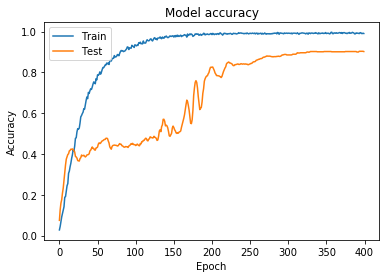

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## With frame_sampling

In [25]:
lr = 2e-6
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [26]:
epochs = 10
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_fine)
        label[Train['fine_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])[:,C.joint_ind,:]
        p = sampling_frame(p,C)
        
        #rotation
        x_angle = np.random.uniform(-0.1,0.1)
        y_angle = np.random.uniform(-0.1,0.1)
        z_angle = np.random.uniform(-0.1,0.1)
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        p = rotaion_one(p,R)
        
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    AR_single.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

    if e%10==0:
        AR_single.save_weights('weights/fine_lite_aug.h5')
        

  1%|          | 23/1960 [00:00<00:08, 224.76it/s]

epoch0


/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:05<00:00, 390.29it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0959 - acc: 0.9801 - val_loss: 0.4277 - val_acc: 0.9000


  1%|          | 18/1960 [00:00<00:11, 172.81it/s]

epoch1


100%|██████████| 1960/1960 [00:05<00:00, 373.95it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 42us/step - loss: 0.0829 - acc: 0.9837 - val_loss: 0.4277 - val_acc: 0.9000


  1%|          | 18/1960 [00:00<00:11, 172.67it/s]

epoch2


100%|██████████| 1960/1960 [00:05<00:00, 386.87it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 40us/step - loss: 0.0815 - acc: 0.9821 - val_loss: 0.4277 - val_acc: 0.9000


  2%|▏         | 40/1960 [00:00<00:04, 397.57it/s]

epoch3


100%|██████████| 1960/1960 [00:04<00:00, 403.01it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 40us/step - loss: 0.0928 - acc: 0.9781 - val_loss: 0.4277 - val_acc: 0.9000


  2%|▏         | 41/1960 [00:00<00:04, 400.35it/s]

epoch4


100%|██████████| 1960/1960 [00:04<00:00, 402.83it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 42us/step - loss: 0.0879 - acc: 0.9827 - val_loss: 0.4277 - val_acc: 0.9000


  2%|▏         | 30/1960 [00:00<00:06, 296.93it/s]

epoch5


100%|██████████| 1960/1960 [00:04<00:00, 402.58it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 41us/step - loss: 0.0858 - acc: 0.9842 - val_loss: 0.4278 - val_acc: 0.9000


  2%|▏         | 41/1960 [00:00<00:04, 401.08it/s]

epoch6


100%|██████████| 1960/1960 [00:04<00:00, 403.83it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 41us/step - loss: 0.0921 - acc: 0.9811 - val_loss: 0.4278 - val_acc: 0.9000


  1%|          | 18/1960 [00:00<00:11, 175.30it/s]

epoch7


100%|██████████| 1960/1960 [00:05<00:00, 380.16it/s]

Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 38us/step - loss: 0.0886 - acc: 0.9811 - val_loss: 0.4279 - val_acc: 0.9000



  2%|▏         | 37/1960 [00:00<00:05, 360.66it/s]

epoch8


100%|██████████| 1960/1960 [00:04<00:00, 397.04it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 40us/step - loss: 0.0846 - acc: 0.9832 - val_loss: 0.4279 - val_acc: 0.9000


  2%|▏         | 33/1960 [00:00<00:05, 321.96it/s]

epoch9


100%|██████████| 1960/1960 [00:04<00:00, 402.61it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 43us/step - loss: 0.0937 - acc: 0.9796 - val_loss: 0.4280 - val_acc: 0.9000


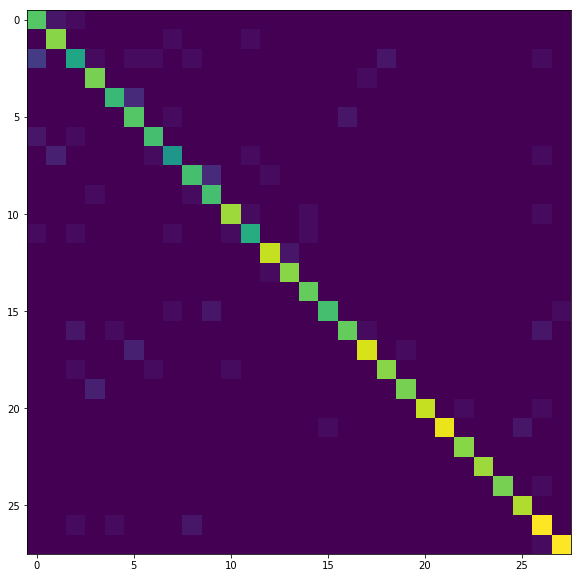

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = AR_single.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()